In [1]:
import  os
#set visibile cuda
os.environ["CUDA_VISIBLE_DEVICES"]="8"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim 
import normflows as nf
device='cuda'
torch.manual_seed(0)


In [3]:
from tools.noise_scheduler import noise_scheduler
from tools.loss import noise_estimation_loss
from tools.score_net import score_model_cond
from tools.sampling import ddpm_sampler

In [4]:
import sbibm
from sbibm.metrics import mmd

task = sbibm.get_task("two_moons")  # See sbibm.get_available_tasks() for all tasks
prior = task.get_prior()
simulator = task.get_simulator()

# These objects can then be used for custom inference algorithms, e.g.
# we might want to generate simulations by sampling from prior:
thetas = prior(num_samples=10000)
samples = simulator(thetas)

In [5]:
import os

obs_loc='/work/dante/scripts/VMEval/dataset/sbibm_tasks/two_moons/files/num_observation_2/'

obs=np.loadtxt(os.path.join(obs_loc,'observation.csv'),delimiter=',',skiprows=1)

true_theta=np.loadtxt(os.path.join(obs_loc,'true_parameters.csv'),delimiter=',',skiprows=1)

ref_posterior=np.loadtxt(os.path.join(obs_loc,'reference_posterior_samples.csv'),delimiter=',',skiprows=1)

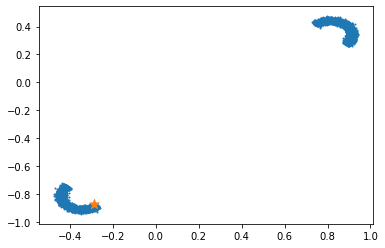

In [6]:

plt.scatter(ref_posterior[:,0],ref_posterior[:,1],s=1)

plt.scatter(true_theta[0],true_theta[1],marker='*',s=100)

In [7]:
ns=noise_scheduler(1e-7,1e-3,100,schedule='sigmoid')

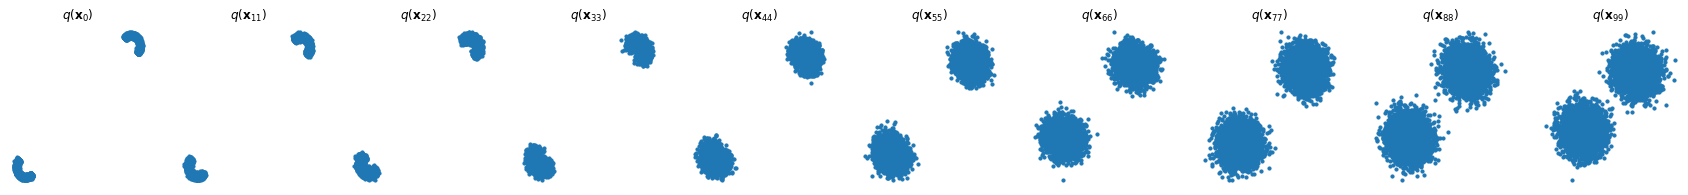

In [8]:
ns.visualize_noise(torch.tensor(ref_posterior))

In [9]:
model = score_model_cond(100,x_dim=2,x_cond_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [10]:
dataset=torch.tensor(samples).float().to(device)
thetas=torch.tensor(thetas).float().to(device)
epochs = 1000
batch_size = 128
for epoch in range(epochs):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = thetas[indices]
        batch_x_cond = dataset[indices]

        t = torch.randint(0, ns.n_steps, size=(batch_x.shape[0] // 2 + 1,))
        t = torch.cat([t, ns.n_steps - t - 1], dim=0)[:batch_x.shape[0]].long().to(device)
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x,t,ns,batch_x_cond)

        optimizer.zero_grad()
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()

    if (epoch % 100 == 0):
        print(loss.item())


/tmp/ipykernel_2871317/4256054674.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset=torch.tensor(samples).float().to(device)
/tmp/ipykernel_2871317/4256054674.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thetas=torch.tensor(thetas).float().to(device)


0.8980927467346191
1.2354364395141602
0.45332497358322144
0.3625367283821106
0.24176384508609772
0.6493608951568604
0.5545854568481445
0.447373628616333
0.47661125659942627
0.16378264129161835


In [18]:
sampler=ddpm_sampler(model,ns.sigmas,ns.n_steps,device=device)

In [19]:
sample_cond=torch.tensor(np.repeat(obs[None,:],thetas.shape[0],axis=0)).float().to(device)
x_seq=sampler.loop_sample(thetas.shape,sample_cond=sample_cond)

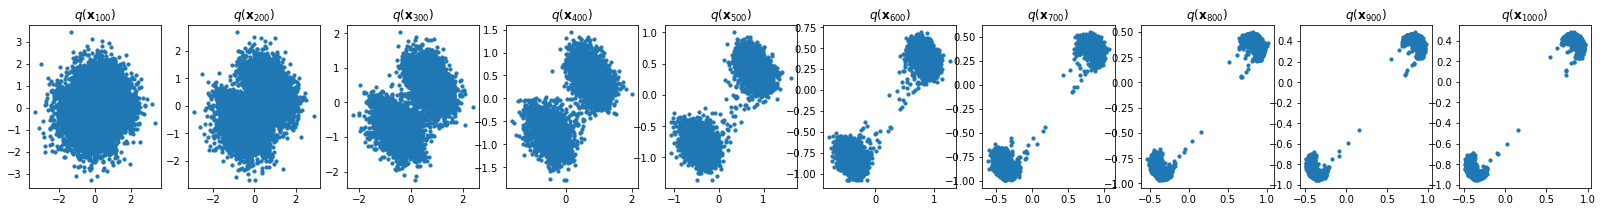

In [20]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(1, 11):
    cur_x = x_seq[i * 10].detach().cpu()
    axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
    #axs[i-1].set_axis_off(); 
    axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

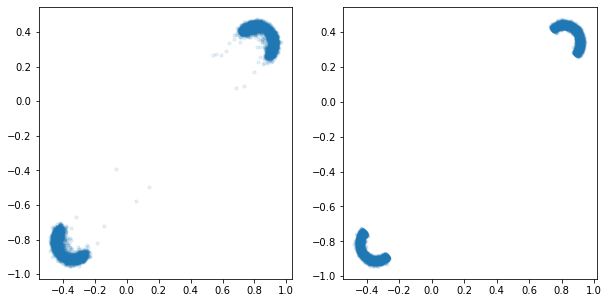

In [24]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(*x_seq[-1].detach().cpu().T, s=10, alpha=0.1)

plt.subplot(1, 2, 2)
plt.scatter(*ref_posterior.T, s=10, alpha=0.1)


(-1.0, 0.5)

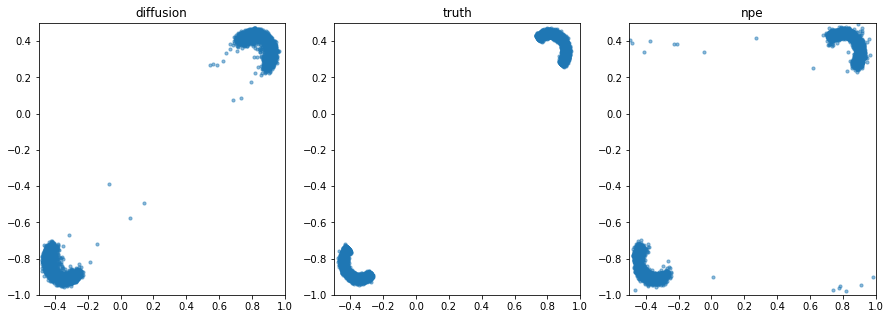

In [25]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(*x_seq[-1].detach().cpu().T, s=10, alpha=0.5)
plt.title('diffusion')
plt.xlim(-0.5,1,1)
plt.ylim(-1,0.5)

plt.subplot(1, 3, 2)
plt.scatter(*ref_posterior.T, s=10, alpha=0.5)
plt.title('truth')
plt.xlim(-0.5,1,1)
plt.ylim(-1,0.5)

nf_re=np.load('nf_twomoon_pos.npy')
plt.subplot(1, 3, 3)
plt.scatter(*nf_re.T, s=10, alpha=0.5)
plt.title('npe')
plt.xlim(-0.5,1,1)
plt.ylim(-1,0.5)